# 🤖 ASR系列-一切開始Whisper模型基礎之聲音與文字

> 透過深入了解 Whisper 網路結構，提高學員對模型推理上的認知
> 日期：2025/10/09-0930

<a href="https://www.tenlong.com.tw/products/9786264142915"><img src="https://github.com/openpipe/art/raw/main/assets/Header_separator.png" height="5"></a>

## 👨‍💻 作者資源與聯絡方式

### 📚 深度學習專書
**📖 《LangGraph 實戰開發 AI Agent 全攻略》** - 我的最新技術著作
深入探討 LangGraph、Agentic AI System 等前沿技術
**[立即購買](https://www.tenlong.com.tw/products/9786264142915)**

### 🌐 社群媒體與技術交流
如果您有任何疑問或想要進一步交流，歡迎透過以下管道聯絡：

* **📖 技術專書**： [購買我的 LangGraph 實戰開發 AI Agent 全攻略](https://www.tenlong.com.tw/products/9786264142915)
* **💻 GitHub**： [我的開源專案](https://github.com/Heng-xiu)
* **🤗 Hugging Face**： [我的模型與資料集](https://huggingface.co/Heng666)
* **✍️ 部落格**： [技術文章分享](https://r23456999.medium.com/)

感謝大家的支持！期待與更多 AI 技術愛好者交流討論 🚀

<div class="align-center">
  <a href="https://ko-fi.com/hengshiousheu"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a>
</div>

<a href="https://www.tenlong.com.tw/products/9786264142915"><img src="https://github.com/openpipe/art/raw/main/assets/Header_separator.png" height="5"></a>



#第一章、聲音與文字介紹

如何將聲音轉化為數位語言？——從連續訊號到 Whisper 的基礎
你有沒有想過，當你對著手機語音助手說話時，背後是如何將你的聲音轉化成機器能理解的資料？聲音，看似簡單，卻是一種充滿細節的物理現象，而要讓像 Whisper 這樣的語音辨識模型發揮作用，第一步就是將聲音從空氣中的波動轉換成數位世界中的一串數字。

這篇文章將帶你一窺聲音數位化的奧秘，並為你理解如何微調 Whisper 奠定基礎。

##1.1-教學流程

本教學將逐步指導您熟悉與了解 Whisper 運作機制

涵蓋以下核心步驟

1. 聲音介紹
2. 文字介紹

# 第二章：環境建置與前置準備
在我們開始微調 Whisper 之前，首先要確保我們的開發環境已經準備就緒。一個穩定且配置正確的環境是成功訓練模型的第一步。

> GPU 啟用： 請確保您的 Colab Notebook 已啟用 GPU。點擊菜單欄的 執行階段 (Runtime) -> 變更執行階段類型 (Change runtime type)，然後在 硬體加速器 (Hardware accelerator) 中選擇 GPU。

##2.1 首先，來登入 HuggingFace

本章節我們先確認在本實驗環境中，可以獲取到 HuggingFace 資源，包含下載資料集、模型等操作

您可以在 Hugging Face Hub 中找到您的 [Hugging Face token](https://huggingface.co/login?next=%2Fsettings%2Ftokens)


In [1]:
from google.colab import userdata
from huggingface_hub import HfApi

HF_TOKEN = userdata.get("HF_TOKEN")

api = HfApi(token=HF_TOKEN)
username = api.whoami()['name']
print(username)

Heng666


## 2.2 GPU 驅動與 CUDA 支援確認

LLM 的訓練需要大量的計算資源，幾乎必須仰賴 GPU (Graphics Processing Unit)。因此，確認您的環境是否正確偵測到 GPU 並支援 CUDA 是至關重要的一步。

CUDA 是 NVIDIA 提供的平行運算平台和程式設計模型，允許軟體使用 GPU 進行通用計算。PyTorch (一個流行的深度學習框架) 透過 CUDA 來利用 NVIDIA GPU 的運算能力。

請執行以下 Python 程式碼，檢查您的 PyTorch 環境是否已正確偵測到 CUDA：

In [ ]:
import torch

print(f"PyTorch 是否支援 CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"目前使用的 CUDA 裝置名稱: {torch.cuda.get_device_name(0)}")
    print(f"CUDA 裝置數量: {torch.cuda.device_count()}")
    # 可以進一步檢查 CUDA 版本
    print(f"PyTorch 編譯的 CUDA 版本: {torch.version.cuda}")
    # 執行 nvidia-smi (僅限 Linux/Windows 終端機，Colab 可直接執行)
    # !nvidia-smi
else:
    print("警告：未偵測到 CUDA。模型訓練將在 CPU 上運行，速度會非常慢。")
    print("請檢查您的 GPU 驅動程式安裝、CUDA Toolkit 設定以及 PyTorch 的 CUDA 支援。")

> 【重要提醒】：如果 torch.cuda.is_available() 回傳 False，您可能需要：

確認您的電腦有 NVIDIA GPU。

安裝正確版本的 NVIDIA 顯示卡驅動程式。

安裝與您 PyTorch 版本相容的 CUDA Toolkit。

對於 Colab 用戶，請再次確認您已在執行階段中選擇了 GPU。

#第三章、如何將聲音轉化為數位語言？

##3.1-數位化的旅程：從聲波到音訊檔案

那麼，聲音是如何從空氣中的波動變成電腦裡的資料呢？讓我們來拆解這個過程：

- 捕捉聲波：一切從麥克風開始。當你對著麥克風說話時，它會將聲波（空氣壓力的變化）轉換成電訊號。這就像把聲音的「波浪」變成了一條可以記錄的電流曲線。

- 數位化過程：接下來，這個電訊號會被送到類比數位轉換器（ADC, Analog-to-Digital Converter）。ADC 就像一位快速的記錄員，以固定的頻率（稱為取樣率）測量電訊號的強度，並將這些測量值轉換成一串數位數值。

- 生成音訊檔案：這些數值最終形成數位化的聲音檔案，也就是你在資料集裡常見的 .wav 或 .flac 檔案。它們就像聲音的「數位DNA」，記錄了聲波的每一個細節。

不同的音訊檔案格式有不同的特點：

- .wav（Waveform Audio File）：這是一種未壓縮的格式，保留了聲音的所有原始細節。檔案大小較大，但音質無損，適合需要高保真的場景，例如 Whisper 的語音資料處理。

- .flac（Free Lossless Audio Codec）：這是一種無損壓縮格式，像是在不損失細節的情況下，將聲音資料「打包」得更小巧。它在儲存空間和音質之間取得了平衡，廣泛應用於高品質音訊儲存。

選擇合適的檔案格式，會直接影響 Whisper 在處理語音資料時的效率與品質。這就像為模型挑選最適合的食材，奠定微調成功的基礎。



##3.2-取樣與取樣率：捕捉聲音的關鍵

要將連續的聲波轉化為數位資料，**取樣（Sampling）**是不可或缺的一步。取樣就像是用快門捕捉聲音的瞬間，以固定的時間間隔測量聲波的強度，生成一串離散的數值。這些數值就像聲音的「數位快照」，記錄了聲波在每個瞬間的狀態。

> 取樣率：決定聲音的細膩度

**取樣率（Sampling Rate）**是指每秒鐘取樣的次數，以赫茲（Hz）為單位。取樣率越高，聲音的細節就越豐富，但檔案大小和計算成本也會隨之增加。以下是幾個常見的取樣率及其應用：

- 44,100 Hz（44.1 kHz）：這是 CD 音質的標準取樣率，每秒捕捉 44,100 次聲波的變化，足以重現人類可聽範圍內的聲音細節。

- 192,000 Hz（192 kHz）：高解析度音訊的取樣率，用於專業錄音或高保真音樂。

- 16,000 Hz（16 kHz）：語音辨識模型（如 Whisper）常用的取樣率，足以捕捉人類語音的關鍵頻率。

> 取樣率的選擇主要決定了訊號中能夠捕獲的最高頻率。這也稱為奈奎斯特極限(Nyquist limit)

##3.3-模型訓練：取樣率一致性的重要性

在準備音訊資料集時，取樣率的一致性至關重要。如果你的資料集包含不同取樣率的音訊檔案，模型可能會因為時間解析度的差異而難以學習。例如：

- 一段 5 秒的聲音，以 16 kHz 取樣會生成 80,000 個數值；而以 8 kHz 取樣則只有 40,000 個數值。

Whisper 這樣的 Transformer 模型將音訊視為一個序列，並依靠注意力機制來學習語音特徵。如果取樣率不一致，序列長度和時間解析度會不同，導致模型難以有效推廣。

因此，當你準備自訂音訊資料來微調 Whisper 時，務必確保所有音訊檔案的取樣率與預訓練資料一致。這就像確保所有拼圖的尺寸相同，才能讓模型順利拼湊出完整的聲音圖像。

##3.4-聲波圖：聲音的視覺化面貌

你有沒有想過，聲音可以被「看見」？透過聲波圖（Waveform），我們能將音訊訊號視覺化為一條隨著時間變化的曲線，顯示聲音振幅的變化。這就像把聲音的「脈搏」畫在圖紙上，讓我們能一目了然地觀察它的特徵。這種表示方式被稱為聲音的時域表示（Time Domain Representation）。

聲波圖有什麼用呢？它能幫助我們：

1. 辨識事件時間點：例如，聲音中某個單詞或噪音出現的具體時刻。
2. 檢查響度：振幅的高低反映了聲音的強弱，讓你知道錄音是否過於安靜或過於刺耳。
3. 偵測雜訊：不規則的波形可能表示背景噪音或錄音品質問題，這對 Whisper 的訓練可能會造成影響。

> 若要開始使用音訊資料集，請確保已安裝🤗資料集庫： pip install datasets[audio]

In [1]:
!pip install --quiet datasets==3.6.0
!pip install --quiet torchcodec==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.7 MB/s eta 0:00:00


##3.4.1-載入音訊資料集：從 PolyAI/minds14 開始

在語音處理的世界中，資料集是模型訓練的基石。而要快速取得高品質的音訊資料，Hugging Face 的 datasets 函式庫是一個強大的工具。它的 `load_dataset()` 函數讓你只需一行 Python 程式碼，就能下載並準備好資料集，省去繁瑣的資料處理步驟。

讓我們以 `PolyAI/minds14` 資料集為例。這個資料集包含了人們以多種語言和方言向電子銀行系統提問的錄音，非常適合用來訓練或微調語音辨識模型，如 Whisper。特別是其中的中文（zh-CN）子集，為我們提供了一個探索語音資料的絕佳起點。

以下是如何載入這個資料集的簡單程式碼：

In [12]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", "zh-CN",split="train")

這一行程式碼會下載並準備好中文語音資料，讓你可以立即開始探索。

###3.4.1-播放音訊：聽見資料的真實面貌

我們將使用🤗 Datasets 庫來處理音訊資料集。 🤗 Datasets 是一個開源程式庫，用於下載和準備包括音訊在內的所有模態的資料集。該庫可以輕鬆存取 Hugging Face Hub 上公開提供的海量機器學習資料集。此外，🤗 Datasets 還包含多項針對音訊資料集的客製化功能，可簡化研究人員和從業人員對此類資料集的使用。


![img](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/datasets/resample-dark.gif)

親耳聽聽音訊資料能讓你更直接地了解它的品質。以下是如何使用 Python 播放 PolyAI/minds14 資料集中第一個音訊範例的程式碼：

In [13]:
from datasets import Audio
# 確保音訊的取樣率一致（例如 16 kHz）
minds = minds.cast_column("audio", Audio(sampling_rate=16000))

# 取得第一個音訊範例
audio = minds[0]["audio"]

In [14]:
from IPython.display import Audio
# 播放音訊
Audio(audio["array"], rate=audio["sampling_rate"])

聽音訊能讓你發現一些視覺化可能忽略的問題，例如語音的清晰度、背景噪音的干擾，或語速的變化。這些資訊對於準備高品質的資料集至關重要

###3.4.2-繪製聲波圖：用 Python 視覺化音訊

要將音訊訊號視覺化為聲波圖，我們可以使用 Python 的 librosa 函式庫，這是一個專為音訊處理設計的強大工具。以下是一個簡單的程式碼範例，用來繪製聲波圖：

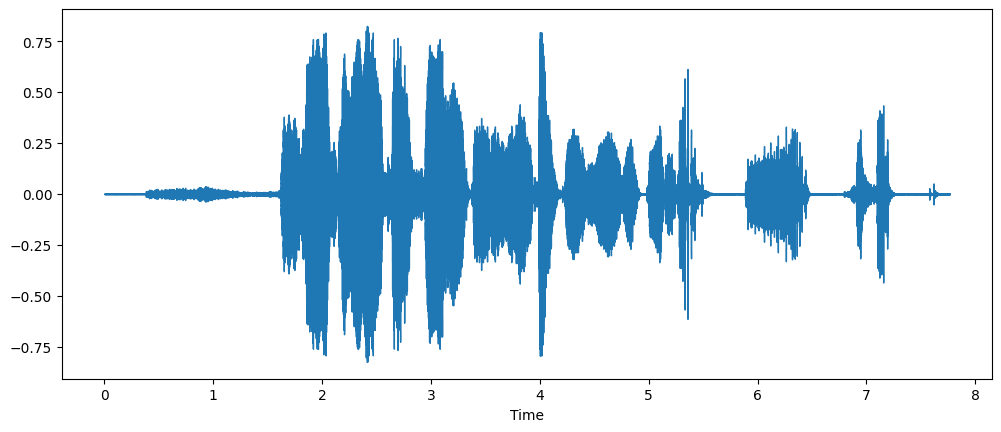

In [15]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

# 設定圖形寬度
plt.figure().set_figwidth(12)

# 繪製聲波圖
librosa.display.waveshow(audio["array"], sr=audio["sampling_rate"])

這會將訊號的幅度繪製在 y 軸上，將時間繪製在 x 軸上。換句話說，每個點都對應著取樣此聲音時的一個樣本值。另請注意，librosa 已經將音訊傳回為浮點值，而振幅值確實在 [-1.0, 1.0] 範圍內。

然而，時域表示（waveform）僅捕捉訊號振幅隨時間的變化，無法解析頻率成分，這限制了對語音特徵如諧波與共振峰的分析。頻譜圖透過離散傅立葉變換（DFT）轉換至頻域，量化各頻率成分的能量分佈，提供語音結構的精確頻譜解析。

##3.5-頻譜圖



頻譜圖（Frequency Spectrum） 就派上用場了。它能揭示聲音在不同頻率上的能量分佈，讓你「看見」聲音是由哪些頻率成分組成的。

頻譜圖將聲音訊號分解成各種頻率成分：

- x 軸：表示頻率（Hz），通常使用對數刻度（log scale），因為人類聽覺對低頻更敏感，高頻分辨率較低。
- y 軸：表示振幅強度（amplitude），常轉換為分貝（dB）單位，以對數方式呈現，更符合人耳的感知。

圖上的尖峰（peaks） 對應聲音中主要的頻率成分。例如，一個在 620 Hz 附近的尖峰，可能來自樂器（如小號）演奏的 E♭ 音。這有助於辨識語音中的元音諧波或輔音爆破聲。

> 頻譜的計算依賴離散傅立葉變換（DFT, Discrete Fourier Transform），它將時域訊號轉換到頻域，揭示各頻率的貢獻與強度。

讓我們使用 numpy 的 rfft() 函數進行 DFT，繪製相同小號聲音的頻譜。雖然可以繪製整個聲音的頻譜，但查看一小塊區域更有用。這裡，我們將對前 4096 個樣本進行 DFT，這大致相當於第一個音符的長度：

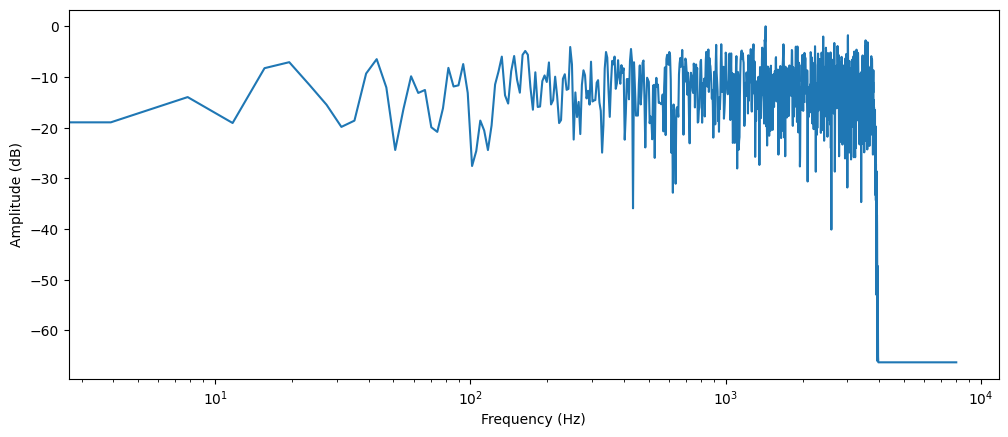

In [17]:
import numpy as np

dft_input = audio["array"][:4096]

# calculate the DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=audio["sampling_rate"], n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

這張圖描繪了該音頻片段中各個頻率成分的強度。頻率值位於 x 軸，通常以對數刻度繪製，而其振幅位於 y 軸。

##3.6-短時傅立葉變換（STFT）：捕捉聲音的動態頻率
頻譜圖（Spectrogram）是一種時頻表示（time-frequency representation），能同時顯示聲音的時間（x 軸）、頻率（y 軸）和振幅（以顏色深淺表示，通常為分貝 dB）。它的核心是短時傅立葉變換（STFT），這是一種將音訊分成短時間片段（通常 20–40 毫秒），對每個片段進行離散傅立葉變換（DFT）的演算法。這樣，你就能看到頻率如何隨時間變化，克服了單一 DFT 無法捕捉時間動態的限制。

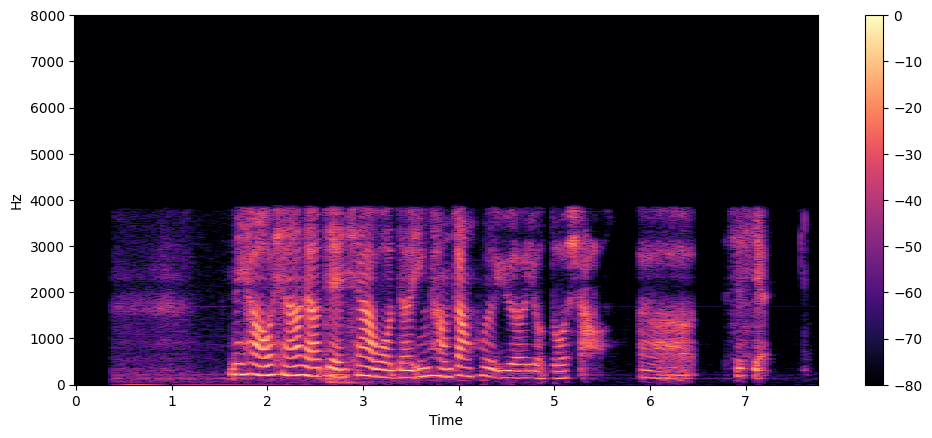

In [18]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# 假設 array 是音訊數值陣列，sampling_rate = 16000
D = librosa.stft(audio["array"])  # 計算 STFT
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)  # 轉為分貝單位

# 繪製頻譜圖
plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz", sr=audio["sampling_rate"])
plt.colorbar()

在該圖中，x 軸與波形視覺化中的 x 軸一樣表示時間，但現在 y 軸表示頻率（單位為赫茲）。顏色的深淺表示每個時間點頻率分量的振幅或功率，以分貝 (dB) 為單位。

##3.7-Mel 頻譜圖：模擬人耳的頻率感知

雖然頻譜圖很強大，但它使用線性頻率刻度（linear frequency scale），與人類聽覺的非線性感知不完全吻合。這就是 **Mel 頻譜圖（Mel Spectrogram）** 的用武之地。Mel 頻譜圖是一種特殊的時頻表示，使用 **Mel 尺度（Mel Scale）**來模擬人耳對頻率的非線性敏感度，特別適用於語音處理和機器學習任務。

![img](https://www.sfu.ca/sonic-studio-webdav/handbook/Graphics/Mel.gif)

以下是使用 Librosa 生成 Mel 頻譜圖的程式碼，針對 16 kHz 音訊（Whisper 標準）：

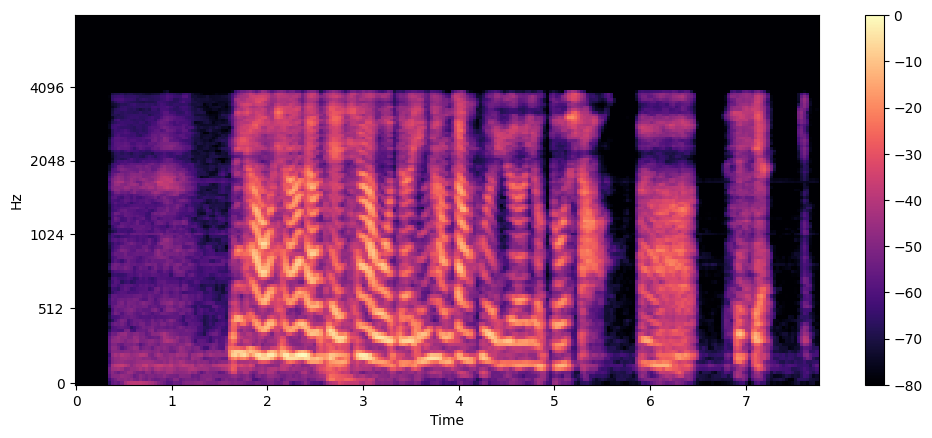

In [31]:
S = librosa.feature.melspectrogram(y=audio["array"], sr=audio["sampling_rate"], n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=audio["sampling_rate"], fmax=8000)
plt.colorbar()

這讓 Mel 頻譜圖更適合語音任務，因為它聚焦於人類聽覺敏感的頻率範圍。



##3.8-Whisper 當中如何使用？

處理音訊資料集最具挑戰性的方面之一是以正確的格式準備資料以進行模型訓練。如您所見，原始音訊資料以樣本值數組的形式出現。然而，對於預訓練模型，無論您將其用於推理，還是希望對其進行微調以完成任務，都需要將原始資料轉換為輸入特徵。不同模型對輸入特徵的要求可能有所不同—它們取決於模型的架構及其預先訓練的資料。

> 好消息是，對於每個支援的音訊模型，🤗 Transformers 都提供了一個特徵提取器類，可以將原始音訊資料轉換為模型所需的輸入特徵。

那麼，特徵提取器如何處理原始音訊資料呢？讓我們來看看 Whisper 的特徵提取器，以了解一些常見的特徵提取轉換。

###3.8.1-對音訊檔案做特徵轉換

特徵截取器會將將填滿後的音訊陣列轉換為對數-梅爾聲譜圖。這些聲譜圖描述了訊號頻率隨時間的變化，以梅爾標度表示，並以分貝（對數部分）為單位進行測量，以使頻率和振幅更符合人類聽覺。

> 之前學這麼多，這邊一行就解決，感謝已經實作過的函數 ＸＤ

In [23]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny")

接下來，您可以編寫一個函數，透過將單一音訊範例傳遞給 feature_extractor 來對其進行預處理。

In [24]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

我們可以使用🤗資料集的 map 方法將資料準備功能應用於所有訓練範例：

In [25]:
minds = minds.map(prepare_dataset)
minds

Map:   0%|          | 0/502 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'input_features'],
    num_rows: 502
})

###3.8.2-視覺化預處理結果

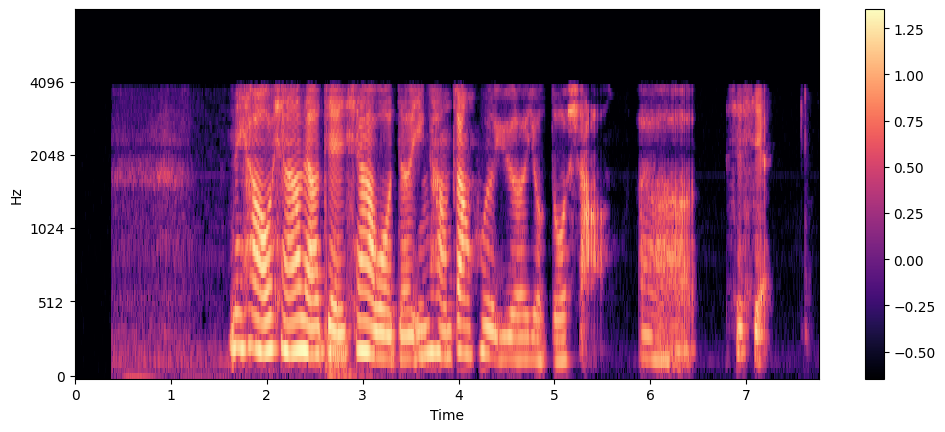

In [32]:
import numpy as np

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
    cmap="magma",
)
plt.colorbar()

#第四章、文字


### Default (English transcription)

| Position | Token ID | Token | Purpose |
|:---------:|:---------:|:------:|:---------|
| 1 | 50259 | `<|en|>` | Force English language |
| 2 | 50359 | `<|transcribe|>` | Force transcription mode |
| 3 | 50363 | `<|notimestamps|>` | Omit timestamps in the output |

To switch to **French transcription**, generate a new set of prompts via the `WhisperProcessor`:


一旦模型載入完畢，您可以透過調整兩個設定欄位來控制 Whisper 如何為其解碼器播種以及禁止哪些標記： forced_decoder_ids 和 suppress_tokens 。

In [33]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(
    "openai/whisper-tiny",
    language="zh",  # "French"
    task="transcribe" # "transcribe"
)

# Generate French decoder prompts
french_forced = processor.get_decoder_prompt_ids(
    language="zh",
    task="transcribe")

print("French forced_decoder_ids:", french_forced)
print(" -> Tokens and meanings:")
for pos, tid in french_forced:
    print(f"  Position {pos}: {tid} -> {processor.tokenizer.convert_ids_to_tokens(tid)}")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

French forced_decoder_ids: [(1, 50260), (2, 50359), (3, 50363)]
 -> Tokens and meanings:
  Position 1: 50260 -> <|zh|>
  Position 2: 50359 -> <|transcribe|>
  Position 3: 50363 -> <|notimestamps|>


`suppress_tokens` 是 Whisper 永遠不會採樣的 token ID 清單（對數機率設定為 −∞）。這些包括基本標點符號和內部標記，以確保輸出清晰的自然語言：

In [36]:
from transformers import WhisperForConditionalGeneration
import torch

model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-tiny",
    torch_dtype=torch.float16,
    device_map="auto",
)


suppressed = model.config.suppress_tokens
print("suppress token ids:", suppressed)
print("suppress tokens:   ", processor.tokenizer.convert_ids_to_tokens(suppressed))

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

suppress token ids: [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362]
suppress tokens:    ['"', '#', '(', ')', '*', '+', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', 'Ġ-', 'Ġ"', 'Ġ(', 'Ġ[', 'ĠâĻ', '>>', 'Ġ>>', '--', "Ġ'", 'ĠâĻª', 'Ġ--', 'Ġ*', 'Ġ:', 'Ġ/', 'Ġ<', 'ãĢĮ', 'ãĢį', 'âĻ', 'Ġ#', 'ĠâĻ«', 'âĻª', 'Ġ]', 'Ġ+', 'Ġ=', 'Ġ-(', 'Ġ)', 'ĠâĻªâĻª', '))', 'Ġ@', 'Ġ{', 'Ġ~', 'Ġ\\', 'Ġ>', 'Ġ;', 'Ġ>>>', 'âĻ«', 'Ġ-[', 'Ġ((', 'Ġ("', 'ãĢİ', 'ãĢı', 'Ġ|', 'Ġ^', '---', 'ĠãĢĮ', 'ĠâĻ¬', 'âĻªâĻª', 'Ġ_', 'Ġ)))', 'Ġ`', '}